# Covid Detection Using Res-Net50
##### - Trained model is saved as 'topmodel.h5'
##### - Highest Validation Accuracy: 91.06%
##### - Accuracy on Random Test set: 91.00%
##### - Gradient - Class Activation Map Displayed (turbo heat map is superimposed on the image)
##### - Tested and got accurate results with foreign dataset

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import shutil
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPool2D

# Image Grouping

In [2]:
ROOT_DIRECTORY = "/Users/yashdeshmukh/Documents/COVID-19_Radiography_Dataset/"

In [3]:
covid_images = pd.read_excel(ROOT_DIRECTORY+"/COVID.metadata.xlsx")
opacity_images = pd.read_excel(ROOT_DIRECTORY+"/Lung_Opacity.metadata.xlsx")
normal_images = pd.read_excel(ROOT_DIRECTORY+"/Normal.metadata.xlsx")
pneumonia_images = pd.read_excel(ROOT_DIRECTORY+"/Viral Pneumonia.metadata.xlsx")
frames_all = [covid_images.head(4), opacity_images.head(4), normal_images.head(4), pneumonia_images.head(4)]
result_all = pd.concat(frames_all)
result_all

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [4]:
NEW_DIR = ("/Users/yashdeshmukh/Documents/all_images/") # All images will be moved to this folder
imgs = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

In [5]:
if not os.path.exists(NEW_DIR):
    os.mkdir(NEW_DIR)
    for i in imgs:
        original_dir = os.path.join(ROOT_DIRECTORY, i+"/")
        for imgfile in glob.iglob(os.path.join(original_dir, "*.png")):
            shutil.copy(imgfile, NEW_DIR)     
    print("Done")
else:
    print("Exists")

Done


In [6]:
counter = {'COVID':0,'Lung_Opacity':0,'Normal':0,'Viral Pneumonia':0} #This counter checks how many images are there per category
for image in imgs:
    for count in glob.iglob(NEW_DIR+image+"*"):
        counter[image] += 1
for item in counter.items():
    print(str(item[0])+": "+str(item[1]))

COVID: 3616
Lung_Opacity: 6012
Normal: 10192
Viral Pneumonia: 1345


In [7]:
train_path  = "/Users/yashdeshmukh/Documents/all_images/train_test_split/train"
valid_path  = "/Users/yashdeshmukh/Documents/all_images/train_test_split/validation"
test_path   = "/Users/yashdeshmukh/Documents/all_images/train_test_split/test"

if not os.path.exists(NEW_DIR+"train_test_split/"):
    os.makedirs(NEW_DIR+"train_test_split/")
    os.makedirs(NEW_DIR+"train_test_split/train/Normal")
    os.makedirs(NEW_DIR+"train_test_split/train/Covid")
    os.makedirs(NEW_DIR+"train_test_split/test/Normal")
    os.makedirs(NEW_DIR+"train_test_split/test/Covid")
    os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
    os.makedirs(NEW_DIR+"train_test_split/validation/Covid")

# Training Data
    for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
        os.remove(i)
    for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
        os.remove(i)
    for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/train/Covid" )
        os.remove(i)

  # Validation Data
    for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
        os.remove(i)
    for i in np.random.choice(replace= False , size= 500 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
        os.remove(i)
    for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/validation/Covid" )
        os.remove(i)

  # Test Data
    for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[0]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
        os.remove(i)
    for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+imgs[2]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
        os.remove(i)
    for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+imgs[3]+"*") ):
        shutil.copy(i , NEW_DIR+"train_test_split/test/Covid" )
        os.remove(i)
        
print("Done")

Done


In [8]:
# Used for image augmentations, so we can have more dimentions for our algorithm to learn from
train_datagenerator = ImageDataGenerator(
    preprocessing_function= preprocess_input, 
    horizontal_flip= True, 
    zoom_range= 0.2, 
    shear_range= 0.2, 
    #rescale= 1./255
)

train = train_datagenerator.flow_from_directory(
    directory= train_path, 
    target_size=(224,224),
)
train.class_indices

Found 7800 images belonging to 2 classes.


{'Covid': 0, 'Normal': 1}

In [9]:
validation_datagenerator = ImageDataGenerator(
    preprocessing_function= preprocess_input
)

valid = validation_datagenerator.flow_from_directory(
    directory= valid_path, 
    target_size=(224,224),
)
valid.class_indices

Found 1000 images belonging to 2 classes.


{'Covid': 0, 'Normal': 1}

In [10]:
test_datagenerator = ImageDataGenerator(
    preprocessing_function= preprocess_input
)

test = train_datagenerator.flow_from_directory(
    directory= test_path, 
    target_size=(224,224), 
    shuffle= False
)
test.class_indices

Found 800 images belonging to 2 classes.


{'Covid': 0, 'Normal': 1}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


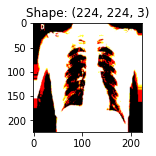

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


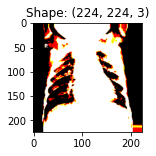

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


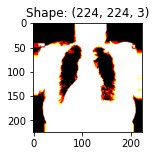

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


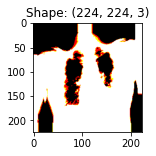

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


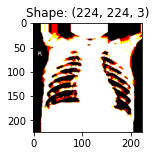

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


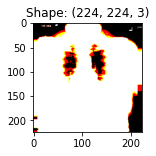

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


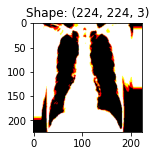

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


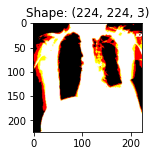

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


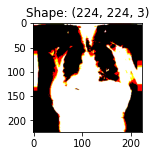

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


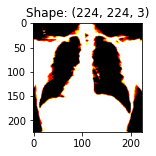

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


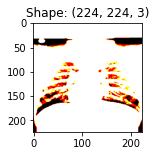

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


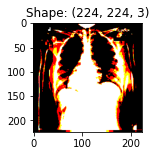

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


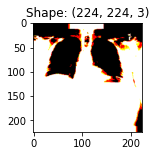

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


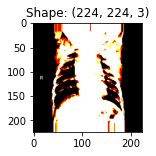

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


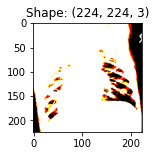

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


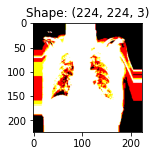

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


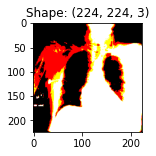

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


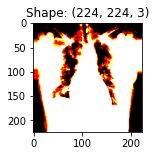

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


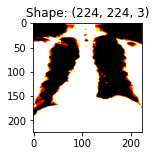

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


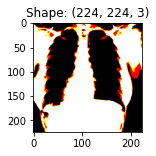

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


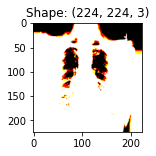

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


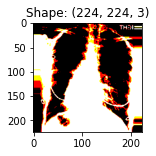

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


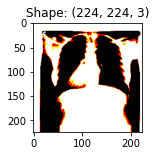

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


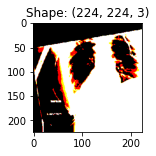

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


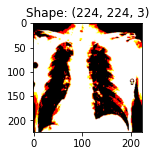

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


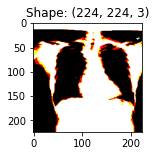

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


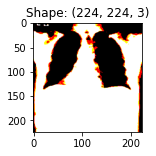

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


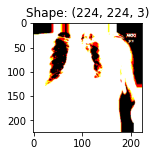

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


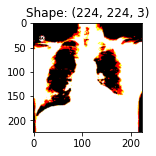

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


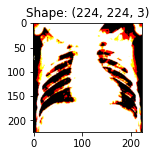

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


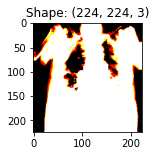

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


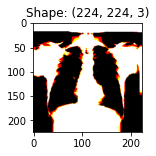

In [11]:
t_img , label = train.next()
# function when called will plot the images 
def plotImages(img_arr, label):
  """
  input= image array 
  output= image plot 
  """
  for im1, l in zip(img_arr,label) :
    plt.figure(figsize= (2,2))
    plt.imshow(im1, cmap = 'gray')
    plt.title("Shape: "+str(im1.shape))
    plt.axis = False
    plt.show()
    
plotImages(t_img, label)

## Will be using ResNet50

In [12]:
from keras.applications.resnet50 import ResNet50
from keras.layers import Flatten , Dense, Dropout , MaxPool2D

In [13]:
res = ResNet50(input_shape=(224,224,3), include_top= False)

In [14]:
for layer in res.layers:           
    layer.trainable = False

In [15]:
x = Flatten()(res.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions')(x)

model = Model(res.input, x)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [17]:
model.compile(
    optimizer= 'adam',
    loss = 'categorical_crossentropy', 
    metrics=['accuracy']
)

In [18]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#To get an optimal accuracy and prevent overfitting. We can also use hyper parameter tuning later on to improve the model furthur.
es = EarlyStopping(
    monitor= "val_accuracy",
    min_delta= 0.01,
    patience= 3,
    verbose=1
)
mc = ModelCheckpoint(
    filepath="topmodel.h5",
    monitor="val_accuracy",
    verbose=1,
    save_best_only= True
)

In [19]:
hist = model.fit_generator(
    train,
    steps_per_epoch= 12,
    epochs= 30,
    validation_data= valid,
    validation_steps= 16,
    callbacks=[es,mc]
)

Epoch 1/30
12/12 [==============================] - 65s 5s/step - loss: 15.1990 - accuracy: 0.5218 - val_loss: 3.7580 - val_accuracy: 0.8164

Epoch 00001: val_accuracy improved from -inf to 0.81641, saving model to topmodel.h5
Epoch 2/30
12/12 [==============================] - 68s 6s/step - loss: 4.8316 - accuracy: 0.7461 - val_loss: 2.5485 - val_accuracy: 0.8672

Epoch 00002: val_accuracy improved from 0.81641 to 0.86719, saving model to topmodel.h5
Epoch 3/30
12/12 [==============================] - 63s 6s/step - loss: 3.9349 - accuracy: 0.8187 - val_loss: 2.1312 - val_accuracy: 0.8809

Epoch 00003: val_accuracy improved from 0.86719 to 0.88086, saving model to topmodel.h5
Epoch 4/30
12/12 [==============================] - 62s 5s/step - loss: 2.7578 - accuracy: 0.8576 - val_loss: 1.2269 - val_accuracy: 0.9160

Epoch 00004: val_accuracy improved from 0.88086 to 0.91602, saving model to topmodel.h5
Epoch 5/30
12/12 [==============================] - 64s 6s/step - loss: 1.8176 - accur

# Model Performance

In [20]:
from keras.models import load_model
model = load_model("topmodel.h5")

In [21]:
#loading the model and checking the training stats
h = hist.history
lst = []
indexlst = []
# for item in h.items():
#     print(str(item[0])+": ")
#     for i in item[1]:
#         print(i)
#     print()
for item in h.items():
    indexlst.append(item[0])
    lst.append(item[1])
hist_df = pd.DataFrame(
    lst,
    index = indexlst,
)
hist_df

,0,1,2,3,4,5,6
loss,12.293896,5.058511,3.648014,2.107581,1.792829,1.405049,1.657752
accuracy,0.572917,0.742021,0.825521,0.880208,0.872396,0.895833,0.856771
val_loss,3.758025,2.548533,2.131204,1.226908,2.038575,0.917879,1.007067
val_accuracy,0.816406,0.867188,0.880859,0.916016,0.880859,0.906250,0.898438


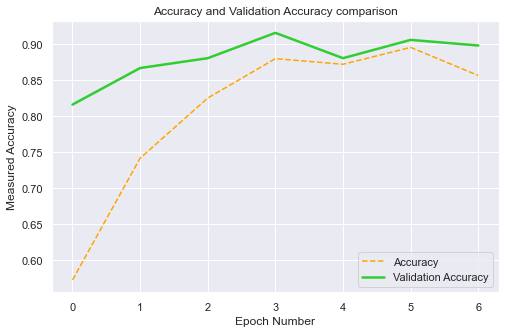

In [22]:
import seaborn as sns
sns.set()
plt.figure(1,figsize=(8, 5))
plt.plot(h['accuracy'], '--b', c = "orange")
plt.plot(h['val_accuracy'], c = "limegreen", linewidth=2.5)
plt.title("Accuracy and Validation Accuracy comparison")
plt.xlabel("Epoch Number")
plt.ylabel("Measured Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"], loc ="lower right")
plt.show()

In [23]:
#Accuracy on Test Dataset
test_accuracy = model.evaluate_generator(generator= test)[1] 
print("Test Accuracy: "+str(test_accuracy))
print("Test Accuracy Percent: "+str(round(test_accuracy,4)*100)+"%")

Test Accuracy: 0.9100000262260437
Test Accuracy Percent: 91.0%


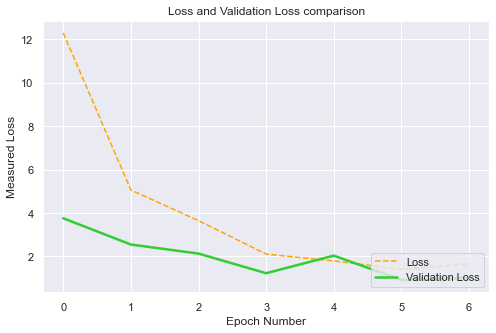

In [24]:
import seaborn as sns
sns.set()
plt.figure(1,figsize=(8, 5))
plt.plot(h['loss'], '--b', c = "orange")
plt.plot(h['val_loss'], c = "limegreen", linewidth=2.5)
plt.title("Loss and Validation Loss comparison")
plt.xlabel("Epoch Number")
plt.ylabel("Measured Loss")
plt.legend(["Loss", "Validation Loss"], loc ="lower right")
plt.show()


# Custom Input Test

In [25]:
from keras.preprocessing import image
import matplotlib.cm as cm

def img_to_array(img_path):
    path = img_path
    img = image.load_img(path, target_size=(224,224,3))
    img = image.img_to_array(img)
    img = np.expand_dims(img , axis= 0) 
    return img

Detected Result: Covid
Covid Guarentee Percent: 99.955%
Not Covid Guarentee Percent: 0.0563%


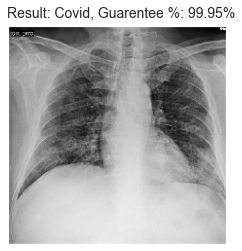

In [27]:
path = "/Users/yashdeshmukh/Documents/all_images/unseendataset/unseen1.jpg" 
img = img_to_array(path)
classes_dict = {0:'Covid',  1 : 'Normal'}
res = classes_dict[np.argmax(model.predict(img))]
print("Detected Result: "+res)
print("Covid Guarentee Percent: "+str(round(model.predict(img)[0][0]*100,4))+"%")
print("Not Covid Guarentee Percent: "+str(round(model.predict(img)[0][1]*100,4))+"%")
plt.xticks([])
plt.yticks([])
plt.imshow(img[0]/255, cmap = "gray")
plt.title("Result: "+res+", Guarentee %: "+str(round(model.predict(img)[0][0]*100,2))+"%", size=14, y=1.01, x=0.52); 
plt.show()

## GRAD-CAM (Gradient - Class Activation Map) 
##### - Used to generate a heatmap to better understand how the model is predicting 

In [28]:

import tensorflow as tf
# Artificial Neural Network's heat map generator
def generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # This model will map the input image to activations of the last convolutional layer and the output predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # w.r.t the activations of the last convolutional layer, we compute the gradient of the top predicted class for our input image
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the predicted output neuron
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    # We multiply each channel in the feature map array by the channel importance w.r.t top predicted class
    # Then all the channels are summed to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    # We will  normalize the heatmap between 0 & 1 for easier visualization.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_result(path,last_conv_layer_name = "conv5_block3_3_conv", model = model):
    """
    Used to predict the type and the ares that are affected
    """
    img_array = img_to_array(path)
    img = img_to_array(path)
    res = classes_dict[np.argmax(model.predict(img))]
    dat = [path,str(res), round(model.predict(img)[0][0]*100,4), round(model.predict(img)[0][1]*100,4)]
    newdf = pd.DataFrame(columns=['Image Path', 'Result', 'Covid Guarentee Percent', 'Not Covid Guarentee Percent'])
    newdf.loc[1] = dat
    return newdf
   
def predict_and_visualize(path,last_conv_layer_name = "conv5_block3_3_conv", model = model):
    """
    Used to predict the type and the ares that are affected
    """
    img_array = img_to_array(path)
    img = img_to_array(path)
    
    heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name)
    plt.figure(1,figsize=(10, 140))
    plt.subplot(1, 3, 1)
    plt.title("Basic Heat Map")
    plt.xticks([])
    plt.yticks([])
    plt.imshow(heatmap, cmap= 'turbo')

    #========== Original Image ===========#
    hm = plt.imread(path)
    plt.subplot(1, 3, 2)
    plt.imshow(hm, cmap = "gray")
    plt.title("Original image")
    plt.xticks([])
    plt.yticks([])
    
    #========== Superimposed Heatmap showing Region of Interest ===========#
    img_path = path
    cam_path="gradcam.jpg"
    alpha=0.4
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)   
    # Rescale heatmap to a range 0-255 and use the turbo colormap
    heatmap = np.uint8(255 * heatmap)
    turbo = cm.get_cmap("turbo")
    turbo_colors = turbo(np.arange(256))[:, :3] #to use RGB values of the colormap
    turbo_heatmap = turbo_colors[heatmap]
    # Generate a RGB colorized heatmap and superimposing it on the original heatmap
    turbo_heatmap = keras.preprocessing.image.array_to_img(turbo_heatmap)
    turbo_heatmap = turbo_heatmap.resize((img.shape[1], img.shape[0]))
    turbo_heatmap = keras.preprocessing.image.img_to_array(turbo_heatmap)
    superimposed_img = turbo_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    # Display Grad CAM
    sup = plt.imread(cam_path)
    plt.subplot(1, 3, 3)
    plt.imshow(sup, cmap = "gray")
    plt.title("Superimposed ROI")
    plt.xticks([])
    plt.yticks([])
    plt.show()

  

# Foreign Predictions

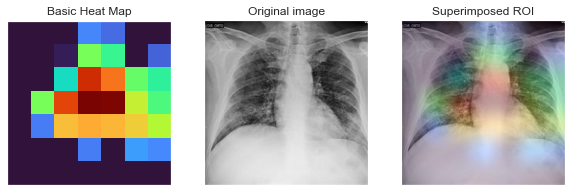

,Image Path,Result,Covid Guarentee Percent,Not Covid Guarentee Percent
1,/Users/yashdeshmukh/Documents/all_images/unsee...,Covid,99.955,0.0563


In [48]:
#1) Checking on a foreign Covid Image 

path = "/Users/yashdeshmukh/Documents/all_images/unseendataset/unseen1.jpg" 
predict_and_visualize(path)
display_result(path)

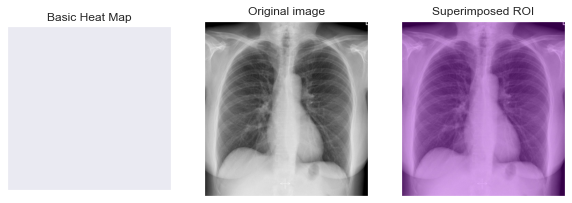

,Image Path,Result,Covid Guarentee Percent,Not Covid Guarentee Percent
1,/Users/yashdeshmukh/Documents/all_images/unsee...,Normal,0.0,100.0


In [37]:
#1) Checking on a foreign Non-Covid Image 
path = "/Users/yashdeshmukh/Documents/all_images/unseendataset/unseen2.jpg" 
predict_and_visualize(path)
display_result(path)

In [31]:
path = "/Users/yashdeshmukh/Documents/all_images/unseendataset/COVID-3.png" 
predict_and_visualize(path)
display_result(path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yashdeshmukh/Documents/all_images/unseendataset/COVID-3.png'